# Topic modeling at the speed of light

Topic modeling is a type of statistical modeling used to discover abstract topics within a collection of documents. It is widely used in natural language processing (NLP) to uncover hidden thematic structures in large text. Traditional topic modeling techniques, such as Latent Dirichlet Allocation (LDA), can be computationally intensive, especially with large datasets. Leveraging GPUs can significantly accelerate the process, making it feasible to handle larger datasets and more complex models.

## Why would you use GPUs?

GPUs (Graphics Processing Units) are designed to handle parallel processing tasks efficiently. They are particularly well-suited for the matrix and vector operations that are common in machine learning and deep learning algorithms. By utilizing GPUs, we can achieve substantial speedups in training and inference times for topic modeling.

Let's get started!

## Setup

First, let's make sure we are running on an runtime with a GPU.

In [1]:
!nvidia-smi

Sat Mar  1 01:12:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             27W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

If the above cell returns an error please make sure that you use a container or runtime with a GPU attached and restart.

To perform the topic modeling we will us [BERTopic](https://maartengr.github.io/BERTopic/index.html), a widely used NLP (Natural Language Processing) framework built on top of BERT embeddings and designed to provide coherent and naturally sounding topic descriptions. So, let's make sure the package is available in our environment.

In [ ]:
# !pip install scikit-learn

In [3]:
!pip install bertopic --quiet

### Imports

RAPIDS provides a new experience that allows you to harness the capabilities of GPUs to run your code authored in pandas or scikit-learn, all *without* the need to change your code in a meaningful way. The Zero-Code-Change (ZCC) experience runs seamlessly on a GPU without doing any additional work on the user's part. And in any case the code to be run on a GPU has not been yet supported, the framwork will then execute the CPU version of the code without any input from the user!

![test](https://rapids.ai/cudf-pandas/chart.png)

To enable this experience, all you need to to is to add these lines on top of your script!

In [4]:
# %load_ext cudf.pandas
# %load_ext cuml.experimental.accel

cuML: Installing experimental accelerator...
cuML: experimental accelerator successfully initialized...


In [ ]:
import cuml
cuml.accel.install()
import cudf.pandas
cudf.pandas.install()

Now that we have the environment set up, we can do our imports.

In [7]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

We are using a bunch of frameworks here. Most of these are fairly selfexplanatory (who doesn't know pandas?!) and we have already touched upon BERTopic. The remaining frameworks help us with the following:

1. [SentenceTransformer](https://www.sbert.net/) is a part of a large collection of over 5000 pre-trained models that help create embeddings we will use to train the topic modeling model.
2. [UMAP](https://umap-learn.readthedocs.io/en/latest/) is a STOA dimensionality reduction tool that is useful with non-linear problems.
3. [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) is a powerful clustering algorithm that uses density-based algorithm (DBSCAN) to find clusters but was further extended to convert it into a hierchical version (hence the HD prefix in the name).

## Download the data
In this example we will be using a Amazon Review dataset and focus on the reviews of beauty products.

In [5]:
!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz --no-check-certificate

--2025-03-01 01:38:06--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
  Unable to locally verify the issuer's authority.
	requested host name ‘mcauleylab.ucsd.edu’.
HTTP request sent, awaiting response... 200 OK
Length: 94441517 (90M) [application/octet-stream]
Saving to: ‘All_Beauty.jsonl.gz.1’

All_Beauty.jsonl.gz 100%[===================>]  90.07M  81.6MB/s    in 1.1s    

2025-03-01 01:38:08 (81.6 MB/s) - ‘All_Beauty.jsonl.gz.1’ saved [94441517/94441517]



The code downloads to a local drive so now we can use pandas like we normally would but all this code actually runs on the GPU!

In [8]:
path = "All_Beauty.jsonl.gz"
data = pd.read_json(path, lines=True)

You can check this for yourself by running the `nvidia-smi` command and you should see about 1GB memory usage on the GPU.

In [9]:
!nvidia-smi

Sat Mar  1 01:39:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             27W /   70W |    1136MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In this particular exercise -- we will only use the first 200k records.

In [10]:
# Limit to e.g., 200K records for demo purposes
N = 200000

data = data.head(N)

Let's have a peek what the data looks like.

In [11]:
data.head()

rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588687728923             0   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588615855070             1   
2  B097R46CSY  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ  1589665266052             2   
3  B09JS339BZ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  1643393630220             0   
4  B08BZ63GMJ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  1609322563534             0   

   verified_purchase  
0               True  
1               True  
2               True  
3               True  
4               True

We have the rating and additional metadata associated with the review. However, we will be using the `text` column only as we are interested in understanding if we can uncover any patterns in the reviews.

In [14]:
sample_docs = data.text.tolist()
sample_docs[0]

"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!"

## Let's have some fun!

Now that we have the data to work with -- let's start our main task: the topic modeling. First, we cannot simply pass text to the BERTopic model and we need to turn each and every sentence into a numerical representation -- an embedding. In this notebook we will use the [`all-MiniLM-L6-v2`](https://huggingface.co/nreimers/MiniLM-L6-H384-uncased) model.

In [16]:
# %%time
import time
start = time.time()
sentence_model_mg = SentenceTransformer("all-MiniLM-L6-v2")
pool = sentence_model_mg.start_multi_process_pool()
embeddings = sentence_model_mg.encode(sample_docs, batch_size=128, show_progress_bar=True, pool=pool)
end = time.time()
print(f"Elapsed time: {end - start:.4f} seconds")

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

CPU times: user 2min 20s, sys: 1.3 s, total: 2min 21s
Wall time: 2min 17s


This process may take a 2 minutes or so but it's a process we only need to do once. Next, now that we have the embeddings, we can train our initial *vanilla* topic model.

In [ ]:
import numpy as np

# Check for zero or duplicate embeddings
zero_rows = np.where(np.linalg.norm(embeddings, axis=1) == 0)
if len(zero_rows) > 0:
    print(f"Zero embeddings found at indices: {zero_rows}")

# Remove duplicates
_, unique_indices = np.unique(embeddings, axis=0, return_index=True)
if len(unique_indices) < len(embeddings):
    print(f"Duplicates found, keeping only unique embeddings.")
    embeddings = embeddings[unique_indices]
    sample_docs = [sample_docs[i] for i in unique_indices]

In [17]:
# %%time
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(sample_docs, embeddings)

Unused keyword parameter: low_memory during cuML estimator initialization
cuML: Performing transform in GPU
Transform can only be run with brute force. Using brute force.
cuML: Performing fit in GPU
cuML: Performing generate_prediction_data in GPU
CPU times: user 41.4 s, sys: 3.08 s, total: 44.5 s
Wall time: 54.3 s


Woot! We have now successfully trained a BERTopic model! On a GPU nonetheless!

Let's explore what we have learned! First, we can quickly discern the most commonly occuring words in each topic (here we only use 8 top topics).

In [10]:
topic_model.visualize_barchart(top_n_topics=8)

So we can clearly see that for each topic -- we see semantically related words. This is good!

But how many topics there are, you ask!? Well...

In [23]:
print(f'The model idenitified {len(set(topics))} distinct topics...')

The model idenitified 581 distinct topics...


That's a lot... Let's see a distribution of how common each topic was.

array([[<Axes: title={'center': '0'}>]], dtype=object)

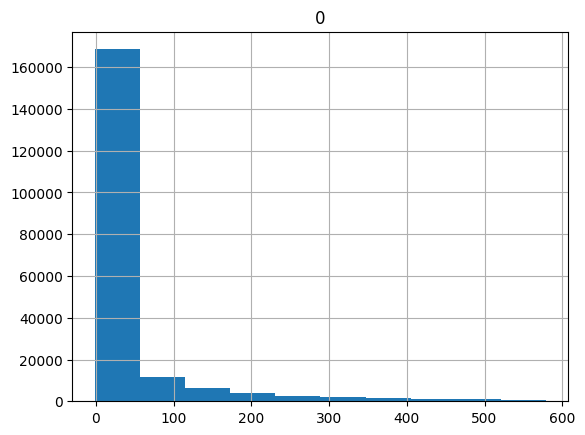

In [26]:
pd.DataFrame(topics).hist()

Well... we're seeing that it's a long tail distribution and likely we can do better than this. Let's see if we're seeing any similarity between these topics before we proceed to refine it.

In [27]:
topic_model.visualize_heatmap(top_n_topics=100)

So the heatmap clearly shows *regions* of similar / overlapping topics (the more blue areas) and patches of less condensed overlap. This is likely better visible on the distance map between topics.

In [28]:
topic_model.visualize_topics()

Okay... There's a lot of topics but **many** overlaps!! We can surely do better than that now that we have this knowledge!

## Clustering to the rescue!

We can use the UMAP to reduce the dimensionality of our dataset and then apply a clustering model (the HDBSCAN) to semantically (since we're working on embeddings!) group some of the reviews into more refined clusters!

And the added benefit -- it all runs on a GPU!!! So no more waiting long time for the UMAP model alone to finish it's job! Running on a GPU gives us the freedom to experiment at a lightning speed!

In [29]:
umap_model = UMAP(n_components=15, n_neighbors=15, min_dist=0.0)
hdbscan_model = HDBSCAN(min_cluster_size=100, gen_min_span_tree=True, prediction_data=True)

topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model)
# %time 
topics, probs = topic_model.fit_transform(sample_docs, embeddings)

topic_model.visualize_topics()

cuML: Performing transform in GPU
Transform can only be run with brute force. Using brute force.
cuML: Performing fit in GPU
cuML: Performing generate_prediction_data in GPU
CPU times: user 1min 20s, sys: 2.99 s, total: 1min 23s
Wall time: 1min 31s


As I was saying... it's quick!

And now we have a much better refined topics (and there's only 105 of them!) Let's see if we still have similar words retained in each topic!

In [32]:
topic_model.visualize_barchart(top_n_topics=16)

Unsurprisingly -- we still do. There are still some topics that could be closely related and viewed as related e.g. topic 0 and topic 6 could be related in some cases when the reviewer talks about how gentle certain shampoos or conditioners are to the skin and how nicely they smell.

Luckily, we used the HDBSCAN and we can quickly pull up these hierarchies.

In [31]:
hierarchical_topics = topic_model.hierarchical_topics(sample_docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 107/107 [00:01<00:00, 84.78it/s]


Nice. So now we can further decide how to further cluster our topics. However, one thing that we saw when we first peeked inside the dataset that there was a ton of short reviews. These reviews are likely skewing our results.

In [33]:
data.head()

rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588687728923             0   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588615855070             1   
2  B097R46CSY  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ  1589665266052             2   
3  B09JS339BZ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  1643393630220             0   
4  B08BZ63GMJ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  1609322563534             0   

   verified_purchase  
0               True  
1               True  
2               True  
3               True  
4               True

Let's see how big of a problem this is for us.

In [35]:
data_word_count = data.text.str.count("\w+")
data_word_count.head()

0    62
1    47
2     4
3     2
4     2
Name: text, dtype: int32

Now let's see the stats!

In [37]:
data_word_count.describe()

count    200000.000000
mean         37.881875
std          53.752225
min           0.000000
25%           9.000000
50%          21.000000
75%          46.000000
max        1620.000000
Name: text, dtype: float64

Alright... So, we see that the median is 21 words - that's a decent length. However, we'd be filtering out half of our reviews. I think 10 words (i.e. over 70% of our dataset) would be usable so let's try that.

In [45]:
# Filter dataframe
longer_reviews = data.loc[data.text.str.count(r"\w+") >= 10]
longer_reviews = longer_reviews.reset_index(drop=True)

# Select embeddings (should match filtered_docs order: both start at zero)
filtered_docs = longer_reviews.text.tolist()
filtered_embeddings = embeddings[longer_reviews.index.values]
filtered_embeddings.shape


(147180, 384)

Good! We still have almost 150k reviews left but we are now guaranteed that these reviews convey a little bit more information than a simple -- "good product".

In [46]:
topic_model_long = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model)
# %time 
topics, probs = topic_model_long.fit_transform(filtered_docs, filtered_embeddings)

cuML: Performing fit in GPU
cuML: Performing transform in GPU
cuML: Performing fit in GPU
cuML: Performing generate_prediction_data in GPU
CPU times: user 58.1 s, sys: 990 ms, total: 59.1 s
Wall time: 1min 3s


How many topics we're seeing now?

In [47]:
print(f'Revised number of topics: {len(set(topics))}')

Revised number of topics: 70


In [48]:
topic_model_long.visualize_topics()

Okay, this looks even better than before! Let's check the word frequencies.

In [49]:
topic_model_long.visualize_barchart(top_n_topics=16)

# Summary

In the end, in less than a few minutes, we have a well defined clusters of topics that the reviewers of beauty products cared to share with us. Thanks to the power of GPU we were able to quickly sift through 200k reviews and come up with up to 70 clearly delineated topics that using HDBSCAN we can further group into logical topics.

And we were able to achieve *all* of this without changing any code that would have run for hours on a CPU.

The power of GPUs gives you the power to build better models faster!

Try it out for yourself!